基准股票池获取：csi300在2022-2025年间数据完整的成分股
==========================
进行股票清洗：退市，暂停上市，数据不足等操作

In [1]:
import akshare as ak
import pandas as pd
from tqdm import tqdm
import time
from datetime import datetime

def get_stable_csi300_stocks(start_date="20220101", end_date="20251228"):
    """
    获取指定时间段内数据完整的沪深300成分股
    """
    print(f"🚀 开始执行数据获取任务")
    print(f"📅 时间范围: {start_date} 至 {end_date}")

    # --- 第一步：获取基准交易日历 ---
    # 使用上证指数(000001)作为基准，计算这段时间理论上应该有多少个交易日
    try:
        # 注意：akshare的日期格式通常要求为 YYYYMMDD
        benchmark_df = ak.stock_zh_index_daily(symbol="sh000001")
        # 转换日期格式以便过滤
        benchmark_df['date'] = pd.to_datetime(benchmark_df['date']).dt.strftime('%Y%m%d')

        # 筛选时间段
        mask = (benchmark_df['date'] >= start_date) & (benchmark_df['date'] <= end_date)
        benchmark_period = benchmark_df.loc[mask]

        total_days = len(benchmark_period)
        print(f"📊 基准交易日总数 (上证指数): {total_days} 天")

        if total_days == 0:
            print("❌ 错误：所选时间段内没有交易数据，请检查日期设置。")
            return None

    except Exception as e:
        print(f"❌ 获取基准日历失败: {e}")
        return None

    # --- 第二步：获取当前的沪深300成分股名单 ---
    try:
        # 获取最新成分股
        print("📥 正在拉取最新的沪深300成分股名单...")
        csi300_cons = ak.index_stock_cons(symbol="000300")
        # csi300_cons columns: ['variety', 'date', 'symbol', 'name', ...]
        print(csi300_cons.columns)
        stock_list = csi300_cons[['品种代码', '品种名称']].values.tolist()
        print(f"✅ 获取成功，共 {len(stock_list)} 只成分股，开始逐一清洗...")
    except Exception as e:
        print(f"❌ 获取成分股名单失败: {e}")
        return None

    # --- 第三步：循环遍历并清洗数据 ---
    clean_stocks = []

    # 设定容忍度：允许缺失 5% 的数据（应对临时停牌），超过则视为不合格
    # 严格模式下，如果您无法接受任何停牌，可以将 0.95 改为 1.0
    threshold = total_days * 0.95

    # 使用 tqdm 显示进度条
    for code, name in tqdm(stock_list, desc="清洗进度"):
        try:
            # 获取个股历史行情 (后复权 adjust='hfq')
            # 强化学习建议使用复权数据，消除分红配股造成的这种价格跳变
            df_stock = ak.stock_zh_a_hist(symbol=code, period="daily", start_date=start_date, end_date=end_date, adjust="hfq")

            actual_days = len(df_stock)

            # 核心筛选逻辑：
            # 1. 实际交易天数 >= 阈值 (排除长期停牌、区间内新上市的股票)
            # 2. 检查是否发生过退市 (当前在CSI300名单里一般未退市，但也可能变成ST)
            # 3. 简单过滤名称中带 ST 的股票（风险警示股）

            is_st = 'ST' in name

            if actual_days >= threshold and not is_st:
                clean_stocks.append({
                    'code': code,
                    'name': name,
                    'actual_days': actual_days,
                    'missing_days': total_days - actual_days,
                    'completeness': round((actual_days / total_days) * 100, 2)
                })

            # 礼貌性延时，防止请求过快被封IP (AkShare 基于爬虫)
            # time.sleep(0.01)

        except Exception as e:
            # 个别股票获取失败不影响整体
            continue

    # --- 第四步：输出结果 ---
    result_df = pd.DataFrame(clean_stocks)

    print("\n" + "="*40)
    print(f"🎉 筛选完成！")
    print(f"原始成分股数: {len(stock_list)}")
    print(f"有效股票数: {len(result_df)}")
    print(f"剔除股票数: {len(stock_list) - len(result_df)}")
    print("="*40)

    return result_df

# --- 执行主程序 ---
if __name__ == "__main__":
    # 获取当前日期作为结束日期 (如果是2025年内)
    # 或者写死 '20251231'
    current_date = datetime.now().strftime('%Y%m%d')
    target_end_date = '20251228' # 根据您的要求

    # 如果当前时间还没到2025年底，防止报错，取较小值
    final_end_date = min(current_date, target_end_date)

    df_clean = get_stable_csi300_stocks(start_date='20220101', end_date=final_end_date)

    if df_clean is not None and not df_clean.empty:
        # 显示前10行
        print(df_clean.head(10))

        # 保存文件
        file_name = "data/csi300_clean_2022_2025.csv"
        df_clean.to_csv(file_name, index=False, encoding="utf-8-sig")
        print(f"\n📂 结果已保存至: {file_name}")

🚀 开始执行数据获取任务
📅 时间范围: 20220101 至 20251228
📊 基准交易日总数 (上证指数): 966 天
📥 正在拉取最新的沪深300成分股名单...
Index(['品种代码', '品种名称', '纳入日期'], dtype='object')
✅ 获取成功，共 300 只成分股，开始逐一清洗...


清洗进度: 100%|██████████| 300/300 [02:24<00:00,  2.07it/s]


🎉 筛选完成！
原始成分股数: 300
有效股票数: 288
剔除股票数: 12
     code  name  actual_days  missing_days  completeness
0  002625  光启技术          966             0        100.00
1  300476  胜宏科技          966             0        100.00
2  300251  光线传媒          966             0        100.00
3  002384  东山精密          966             0        100.00
4  603893   瑞芯微          966             0        100.00
5  300803   指南针          966             0        100.00
6  601456  国联民生          956            10         98.96
7  600522  中天科技          966             0        100.00
8  601018   宁波港          966             0        100.00
9  300866  安克创新          966             0        100.00

📂 结果已保存至: data/csi300_clean_2022_2025.csv


对csv文件按照code进行去重
==========================
使用pandas对csv文件按照code列进行去重操作，保留第一次出现的

In [2]:
import pandas as pd

# 读取 CSV（根据需要加上 encoding='gbk' 或其他编码）
df = pd.read_csv('data/csi300_clean_2022_2025.csv', dtype={'code': str})

# 去重：按 `code` 列，keep='first' 保留第一次出现的行；若想保留最后一次改为 keep='last'
dedup = df.drop_duplicates(subset=['code'], keep='first')

# 保存结果
dedup.to_csv('data/csi300_clean_2022_2025.csv', index=False)

# 可选：打印去重前后数量
print(f"去重前: {len(df)} 行，去重后: {len(dedup)} 行")


去重前: 288 行，去重后: 268 行


个股对应的申万一级行业分类获取
==========================
使用baostock获取申万一级行业分类

In [3]:
import pandas as pd
import baostock as bs
import os

def get_sw_industry_data(input_file, output_file):
    # -----------------------------------------------------------
    # 1. 读取并清洗用户CSV文件
    # -----------------------------------------------------------
    print(f"正在读取文件: {input_file} ...")
    if not os.path.exists(input_file):
        print(f"错误：找不到文件 {input_file}")
        return

    # 读取CSV，强制将code列读取为字符串，防止前导0丢失
    df_user = pd.read_csv(input_file, dtype={'code': str})

    # 确保code是6位，不足补0 (以防万一)
    df_user['code'] = df_user['code'].apply(lambda x: x.zfill(6))

    print(f"用户股票池数量: {len(df_user)}")

    # -----------------------------------------------------------
    # 2. 登陆 Baostock 并获取全市场行业分类
    # -----------------------------------------------------------
    print("正在登陆 Baostock 系统...")
    lg = bs.login()
    if lg.error_code != '0':
        print(f"登陆失败: {lg.error_msg}")
        return

    print("正在获取全市场申万行业分类数据（这可能需要几秒钟）...")

    # 获取全市场所有股票的行业分类
    # date参数设为最近的日期即可，行业分类通常变动不频繁
    # 我们查询当前最新的全市场列表
    rs = bs.query_stock_industry()

    industry_list = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，格式：[code, code_name, industry, industryClassification]
        # industryClassification 为 "申万一级" 等标准
        industry_list.append(rs.get_row_data())

    # 转化为DataFrame
    df_industry = pd.DataFrame(industry_list, columns=rs.fields)

    # 登出系统
    bs.logout()

    print(f"获取到全市场股票行业数据: {len(df_industry)} 条")

    # -----------------------------------------------------------
    # 3. 数据处理与合并
    # -----------------------------------------------------------
    # Baostock的code格式为 "sh.600000" 或 "sz.000001"
    # 我们需要拆分出纯数字代码以便与您的CSV匹配
    df_industry['clean_code'] = df_industry['code'].apply(lambda x: x.split('.')[1])

    # 筛选有用的列：代码、申万一级行业
    # Baostock返回的 'industry' 字段即为 申万一级行业
    df_industry_clean = df_industry[['clean_code', 'industry']].rename(
        columns={'clean_code': 'code', 'industry': 'sw_level1'}
    )

    # 将空值填充为 "未分类"
    df_industry_clean['sw_level1'] = df_industry_clean['sw_level1'].replace("", "未分类")

    # -----------------------------------------------------------
    # 4. 合并数据 (Left Join)
    # -----------------------------------------------------------
    print("正在匹配行业数据...")
    # 这里的 'code' 是连接键
    df_result = pd.merge(df_user, df_industry_clean, on='code', how='left')

    # 处理匹配不到的情况（通常是退市股票或新股）
    df_result['sw_level1'] = df_result['sw_level1'].fillna('未分类/匹配失败')

    # -----------------------------------------------------------
    # 5. 输出结果
    # -----------------------------------------------------------
    df_result.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"成功！结果已保存至: {output_file}")
    print("\n数据预览:")
    print(df_result[['code', 'name', 'sw_level1']].head().to_markdown(index=False))

# 执行主程序
if __name__ == "__main__":
    # 输入文件名 (您上传的文件名)
    input_csv = 'data/csi300_clean_2022_2025.csv'
    # 输出文件名
    output_csv = 'data/csi300_with_industry_2022_2025.csv'

    try:
        get_sw_industry_data(input_csv, output_csv)
    except Exception as e:
        print(f"发生未知错误: {e}")

正在读取文件: data/csi300_clean_2022_2025.csv ...
用户股票池数量: 268
正在登陆 Baostock 系统...
login success!
正在获取全市场申万行业分类数据（这可能需要几秒钟）...
logout success!
获取到全市场股票行业数据: 5493 条
正在匹配行业数据...
成功！结果已保存至: data/csi300_with_industry_2022_2025.csv

数据预览:
|   code | name     | sw_level1                                   |
|-------:|:---------|:--------------------------------------------|
| 002625 | 光启技术 | C37铁路、船舶、航空航天和其他运输设备制造业 |
| 300476 | 胜宏科技 | C39计算机、通信和其他电子设备制造业         |
| 300251 | 光线传媒 | R87广播、电视、电影和录音制作业             |
| 002384 | 东山精密 | C39计算机、通信和其他电子设备制造业         |
| 603893 | 瑞芯微   | C39计算机、通信和其他电子设备制造业         |


2022-202512.31的日度收益率（涨跌幅）获取
===================
从麟龙数据库中获得数据（需关闭vpn）
目前只有2024年-最新日期数据，需等待2022-2024年末数据补齐后再运行

In [4]:
import pandas as pd
import time
import os
from tqdm import tqdm
from clickhouse_driver import Client


def create_client():
    """创建带有更好超时设置的客户端"""
    return Client(
        host='172.29.34.23',
        port=9000,  # 使用原生协议端口 9000，而非 HTTP 端口 8123
        user='bigniu',
        password='NO5LewPV0KQanGNO',
        database='dws',
        connect_timeout=30,
        send_receive_timeout=300,
        sync_request_timeout=10,
    )


def execute_with_retry(client, sql, max_retries=5, base_delay=2):
    """
    带指数退避重试逻辑的查询执行函数
    """
    for attempt in range(max_retries):
        try:
            # 首次失败后，强制重新连接
            if attempt > 0:
                try:
                    client.disconnect()
                except:
                    pass
                time.sleep(base_delay * (2 ** attempt))  # 指数退避

            data, columns = client.execute(sql, with_column_types=True)
            return data, columns
        except (EOFError, ConnectionError, Exception) as e:
            error_msg = str(e)
            if "EOF" in error_msg or "Connection" in error_msg or "Unexpected" in error_msg:
                if attempt == max_retries - 1:
                    raise e
                print(f"  ⚠️ 连接错误 (尝试 {attempt + 1}/{max_retries}): {e}")
            else:
                raise e
    return None, None


# 创建客户端
client = create_client()

# 读取股票列表
csv_path = 'data/csi300_clean_2022_2025.csv'
df_csv = pd.read_csv(csv_path, dtype={'code': str})  # 强制 code 为 str
stock_codes = df_csv['code'].unique()

# 确保所有代码都是 6 位（补齐前导零）
stock_codes = [str(code).zfill(6) for code in stock_codes]

# 支持断点续传：跳过已处理的股票
output_file = 'data/stock_returns_daily.csv'
processed_codes = set()
try:
    existing_df = pd.read_csv(output_file)
    processed_codes = set(existing_df['code'].unique())
    print(f"📂 已加载 {len(processed_codes)} 只已处理的股票，将跳过")
except FileNotFoundError:
    pass

# 过滤待处理的股票
stocks_to_process = [code for code in stock_codes if code not in processed_codes]
print(f"🚀 开始获取 {len(stocks_to_process)} 只股票的日度涨跌幅数据...")

all_results = []
failed_stocks = []

for i, code in enumerate(tqdm(stocks_to_process, desc="数据抓取进度")):
    single_sql = f"""
    SELECT
        code,
        timestamps,
        ChangePCT
    FROM stock_index_d
    WHERE code = '{code}'
      AND timestamps >= '2022-01-01 00:00:00'
      AND category = 'stock'
    ORDER BY timestamps
    """

    try:
        data, columns = execute_with_retry(client, single_sql)

        if data:
            df_temp = pd.DataFrame(data, columns=[col[0] for col in columns])
            all_results.append(df_temp)

            # 每处理 20 只股票，增量保存一次
            if len(all_results) % 20 == 0 and all_results:
                df_batch = pd.concat(all_results, ignore_index=True)
                # 追加到文件
                file_exists = os.path.exists(output_file)
                df_batch.to_csv(output_file, mode='a',
                                header=not file_exists,
                                index=False)
                all_results = []  # 清空缓冲区
                print(f"  💾 已保存进度 ({i + 1}/{len(stocks_to_process)})")
        else:
            print(f"  ⚠️ 股票 {code} 无数据")

    except Exception as e:
        print(f"❌ 股票 {code} 获取失败: {e}")
        failed_stocks.append(code)

    # 请求间添加小延迟，避免服务器过载
    time.sleep(0.5)

# 保存剩余结果
if all_results:
    df_final = pd.concat(all_results, ignore_index=True)
    file_exists = os.path.exists(output_file)
    df_final.to_csv(output_file, mode='a',
                    header=not file_exists,
                    index=False)

print(f"\n✅ 完成! 失败股票数: {len(failed_stocks)}")
if failed_stocks:
    print(f"❌ 失败列表: {failed_stocks}")

🚀 开始获取 268 只股票的日度涨跌幅数据...


数据抓取进度:   7%|▋         | 19/268 [00:14<03:03,  1.36it/s]

  💾 已保存进度 (20/268)


数据抓取进度:  15%|█▍        | 39/268 [00:28<02:37,  1.46it/s]

  💾 已保存进度 (40/268)


数据抓取进度:  22%|██▏       | 59/268 [00:43<02:27,  1.41it/s]

  💾 已保存进度 (60/268)


数据抓取进度:  29%|██▉       | 79/268 [00:57<02:15,  1.39it/s]

  💾 已保存进度 (80/268)


数据抓取进度:  37%|███▋      | 99/268 [01:11<01:58,  1.43it/s]

  💾 已保存进度 (100/268)


数据抓取进度:  44%|████▍     | 119/268 [01:26<01:53,  1.31it/s]

  💾 已保存进度 (120/268)


数据抓取进度:  52%|█████▏    | 139/268 [01:40<01:31,  1.41it/s]

  💾 已保存进度 (140/268)


数据抓取进度:  59%|█████▉    | 159/268 [01:55<01:29,  1.21it/s]

  💾 已保存进度 (160/268)


数据抓取进度:  67%|██████▋   | 179/268 [02:10<01:05,  1.37it/s]

  💾 已保存进度 (180/268)


数据抓取进度:  74%|███████▍  | 199/268 [02:24<00:49,  1.39it/s]

  💾 已保存进度 (200/268)


数据抓取进度:  82%|████████▏ | 219/268 [02:39<00:35,  1.40it/s]

  💾 已保存进度 (220/268)


数据抓取进度:  89%|████████▉ | 239/268 [02:53<00:19,  1.52it/s]

  💾 已保存进度 (240/268)


数据抓取进度:  97%|█████████▋| 259/268 [03:07<00:06,  1.41it/s]

  💾 已保存进度 (260/268)


数据抓取进度: 100%|██████████| 268/268 [03:14<00:00,  1.38it/s]


✅ 完成! 失败股票数: 0


检查麟龙获得的个股日度数据，股票数量是否减少
==========================
对比个股日度数据和成分股列表，检查是否有股票数据缺

In [5]:
# python
import pandas as pd

# 读取 CSV（根据需要改 encoding）
df = pd.read_csv('data/stock_returns_daily.csv', encoding='utf-8')

col = 'code'
if col not in df.columns:
    raise KeyError(f"列 `{col}` 不存在于 CSV")

# 去掉 NaN 后统计不重复值数量
unique_count = df[col].dropna().nunique()
print(f"不重复的 `{col}` 值数量: {unique_count}")

不重复的 `code` 值数量: 268


获取时间窗口内的月度无风险国债利率
==========================
数据来源于akshare

正在获取中国国债收益率数据...


  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\2077325070.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = data.resample('M').last()


成功获取 49 条月度数据。
            Annualized_Rf_Percent  Monthly_Rf_Rate  Monthly_Rf_Rate_Percent
日期                                                                         
2025-08-31                 1.8379         0.001519                 0.151883
2025-09-30                 1.8605         0.001537                 0.153735
2025-10-31                 1.7954         0.001484                 0.148399
2025-11-30                 1.8412         0.001522                 0.152154
2025-12-31                 1.8473         0.001527                 0.152653
数据已保存至 data/china_monthly_risk_free_rate_2022_now.csv
图表已保存为 china_risk_free_rate_plot.png


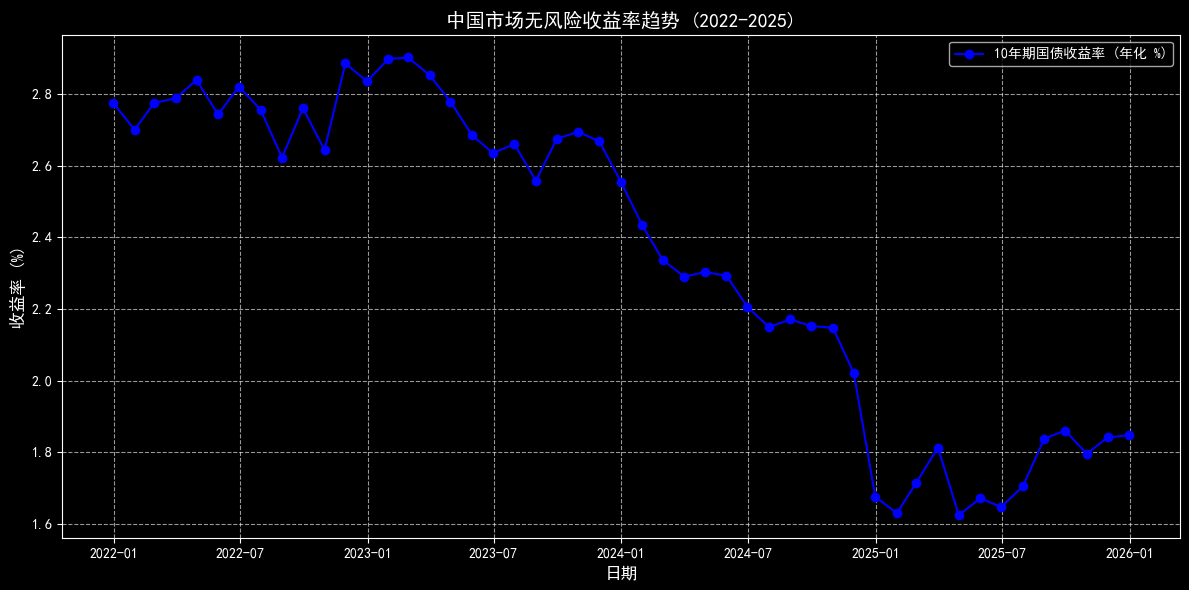

In [6]:
# import os
# os.environ["TQDM_DISABLE"] = "0"  # tqdm 进度条
# # 补丁：让 tqdm 始终使用标准版本
# import tqdm
# import tqdm.std
# tqdm.tqdm = tqdm.std.tqdm
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt




# 设置中文字体（避免绘图乱码，Windows下通常为SimHei，Mac下为Arial Unicode MS）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def get_china_monthly_risk_free_rate(start_date="2021-12-01"):
    print("正在获取中国国债收益率数据...")

    # 1. 获取中美国债收益率历史数据
    # 该接口返回的数据列通常包含：日期, 中国国债收益率2年, 5年, 10年, 30年, 10年-2年, 10年-5年, 美国国债...
    try:
        df = ak.bond_zh_us_rate()
    except Exception as e:
        print(f"数据获取失败，请检查网络或akshare版本: {e}")
        return

    # 2. 数据预处理
    # 转换日期格式
    df['日期'] = pd.to_datetime(df['日期'])

    # 筛选时间范围 (2022年至今)
    mask = df['日期'] >= pd.to_datetime(start_date)
    df_filtered = df.loc[mask].copy()

    # 提取需要的列：日期 和 中国国债收益率10年
    # 注意：列名可能是 "中国国债收益率10年"
    target_col = "中国国债收益率10年"
    if target_col not in df_filtered.columns:
        print(f"未找到列名 {target_col}，现有列名: {df_filtered.columns}")
        return

    data = df_filtered[['日期', target_col]].copy()
    data.set_index('日期', inplace=True)

    # 3. 重采样为月度数据
    # 'M' 代表月末，取每月的最后一个有效值
    df_monthly = data.resample('M').last()

    # 4. 计算月度无风险收益率
    # 原始数据是年化收益率（百分比，例如 2.8%）
    # Monthly Rate (Exact) = (1 + Annual_Yield/100)^(1/12) - 1

    df_monthly.rename(columns={target_col: 'Annualized_Rf_Percent'}, inplace=True)

    # 计算实际的月度收益率 (Decimal format, e.g., 0.0023)
    df_monthly['Monthly_Rf_Rate'] = (1 + df_monthly['Annualized_Rf_Percent'] / 100) ** (1/12) - 1

    # 为了方便查看，也可以保留一个百分比格式的月度收益率
    df_monthly['Monthly_Rf_Rate_Percent'] = df_monthly['Monthly_Rf_Rate'] * 100

    # 删除缺失值（如果有月份数据缺失）
    df_monthly.dropna(inplace=True)

    print(f"成功获取 {len(df_monthly)} 条月度数据。")
    print(df_monthly.tail())

    # 5. 保存到 CSV
    filename = 'data/china_monthly_risk_free_rate_2022_now.csv'
    df_monthly.to_csv(filename)
    print(f"数据已保存至 {filename}")

    # 6. 可视化展现
    plt.figure(figsize=(12, 6))

    # 绘制年化收益率趋势
    plt.plot(df_monthly.index, df_monthly['Annualized_Rf_Percent'], marker='o', linestyle='-', color='b', label='10年期国债收益率 (年化 %)')

    plt.title('中国市场无风险收益率趋势 (2022-2025)', fontsize=14)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('收益率 (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()

    # 保存图片
    plt.savefig('data/china_risk_free_rate_plot.png')
    print("图表已保存为 china_risk_free_rate_plot.png")
    plt.show()

if __name__ == "__main__":
    get_china_monthly_risk_free_rate()

csi300成分股的Fama-French三因子数据构造（可直接获得的数据）
==========================
五类因子：市场因子（MKT）、规模因子（SMB）、价值因子（HML）、盈利能力因子（RMW）、投资风格因子（CMA）
月度数据的获取需要依据各个因子的分类标准自行对全A股构建对应的投资组合，通过组合之间的差值确定各个因子的月度数据
然后利用3年的月度数据进行回归，获得个股在每个因子上的暴露度值

In [7]:
import akshare as ak
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from tqdm import tqdm

# ==========================================
# 1. 配置与增强型数据获取函数
# ==========================================
START_DATE = "20220101"
# 获取当前日期
END_DATE = datetime.now().strftime("%Y%m%d")

def get_index_monthly_return(symbol, name, fallback_symbol=None):
    """
    尝试使用 ak.index_zh_a_hist (东方财富源) 获取指数数据。
    如果失败且提供了 fallback_symbol，则尝试备用指数。
    """
    def _fetch(code):
        try:
            # period="daily" 是默认值
            # 东方财富接口通常不需要 sh/sz 前缀，直接传数字代码
            clean_code = code.replace("sh", "").replace("sz", "")
            df = ak.index_zh_a_hist(symbol=clean_code, period="daily", start_date=START_DATE, end_date=END_DATE)
            if df is None or df.empty:
                return None
            return df
        except:
            return None

    print(f"📥 正在获取 {name} ({symbol})...")
    df = _fetch(symbol)

    # 如果首选失败且有备选
    if df is None and fallback_symbol:
        print(f"⚠️ {name} ({symbol}) 获取失败，尝试备用指数 ({fallback_symbol})...")
        df = _fetch(fallback_symbol)

    if df is None or df.empty:
        print(f"❌ {name} 数据获取完全失败，将使用全0填充！")
        return pd.Series(0.0, dtype=float)

    # 数据清洗
    df['日期'] = pd.to_datetime(df['日期'])
    df.set_index('日期', inplace=True)

    # 重采样为月度收益率 (收盘价)
    # 逻辑：月末收盘价 / 上月末收盘价 - 1
    monthly_series = df['收盘'].resample('M').last()
    ret_monthly = monthly_series.pct_change() # 第一个月会是NaN
    ret_monthly.name = name

    return ret_monthly

# ==========================================
# 2. 构建 Fama-French 因子 (改进版)
# ==========================================
print("\n🚀 第一步：构建月度因子数据")

# 2.1 获取指数数据 (使用更稳定的代码)
# Mkt: 优先用 000985 (中证全指), 备用 000001 (上证指数)
mkt_base = get_index_monthly_return("000985", "Mkt_Base", fallback_symbol="000001")

# SMB: Big=沪深300(000300), Small=中证1000(000852)
big_cap = get_index_monthly_return("000300", "Big")
small_cap = get_index_monthly_return("000852", "Small")

# HML: Value=300价值(000919), Growth=300成长(000918)
# 备用: 国证价值(399371), 国证成长(399370)
value_style = get_index_monthly_return("000919", "Value", fallback_symbol="399371")
growth_style = get_index_monthly_return("000918", "Growth", fallback_symbol="399370")

# 2.2 合并因子
factors_df = pd.concat([mkt_base, big_cap, small_cap, value_style, growth_style], axis=1)

# 2.3 读取无风险收益率 (从您提供的文件中)
try:
    rf_df = pd.read_csv("data/china_monthly_risk_free_rate_2022_now.csv")
    # 假设列名是 '日期' 和 'Monthly_Rf_Rate'
    rf_df['日期'] = pd.to_datetime(rf_df['日期'])
    rf_df.set_index('日期', inplace=True)

    # 确保是月末索引
    rf_df = rf_df.resample('M').last()

    # 合并 Rf
    factors_df = factors_df.join(rf_df['Monthly_Rf_Rate'], how='left')

    # 填充缺失的 Rf (防止某个月对不上)
    factors_df['Monthly_Rf_Rate'] = factors_df['Monthly_Rf_Rate'].fillna(0.002)

except Exception as e:
    print(f"⚠️ 读取无风险利率文件失败: {e}，将使用默认值 0.2%")
    factors_df['Monthly_Rf_Rate'] = 0.002

# 2.4 计算最终因子
# 剔除无法计算收益率的前期数据
factors_df.dropna(inplace=True)

# MKT_RF = 市场回报 - Rf
factors_df['MKT_RF'] = factors_df['Mkt_Base'] - factors_df['Monthly_Rf_Rate']

# SMB = 小盘 - 大盘
factors_df['SMB'] = factors_df['Small'] - factors_df['Big']

# HML = 价值 - 成长
factors_df['HML'] = factors_df['Value'] - factors_df['Growth']

print("\n✅ 因子构建完成，样本如下:")
print(factors_df[['MKT_RF', 'SMB', 'HML']].tail())

# ==========================================
# 3. 计算个股暴露度 (回归分析)
# ==========================================
print("\n🚀 第二步：计算个股因子暴露度")

# 读取您的个股日度回报文件
try:
    stock_df = pd.read_csv("data/stock_returns_daily.csv")
    # 格式化代码为 6 位字符串 (如 2625 -> 002625)
    stock_df['code'] = stock_df['code'].apply(lambda x: f"{int(x):06d}")
    stock_df['timestamps'] = pd.to_datetime(stock_df['timestamps'])

    # 读取股票池名单（仅计算池内股票）
    pool_df = pd.read_csv("data/csi300_clean_2022_2025.csv")
    pool_df['code'] = pool_df['code'].apply(lambda x: f"{int(x):06d}")
    valid_codes = set(pool_df['code'].unique())

except Exception as e:
    print(f"❌ 读取个股数据失败: {e}")
    valid_codes = []

results = []

# 遍历每只股票
# 为了效率，我们先按 code 分组
if len(valid_codes) > 0:
    grouped = stock_df.groupby('code')

    for code, group in tqdm(grouped, total=len(grouped)):
        if code not in valid_codes:
            continue

        group = group.set_index('timestamps').sort_index()

        # 将个股日度回报 -> 月度回报
        # 复利公式: (1+r1)*(1+r2)... - 1
        monthly_ret = group['ChangePCT'].resample('M').apply(lambda x: (1 + x).prod() - 1)
        monthly_ret.name = 'Stock_Ret'

        # 合并个股数据与因子数据
        reg_data = pd.concat([monthly_ret, factors_df[['MKT_RF', 'SMB', 'HML', 'Monthly_Rf_Rate']]], axis=1).dropna()

        # 至少需要 6 个月的数据才能回归
        if len(reg_data) < 6:
            continue

        # 计算超额回报 Y
        Y = reg_data['Stock_Ret'] - reg_data['Monthly_Rf_Rate']

        # 自变量 X
        X = reg_data[['MKT_RF', 'SMB', 'HML']]
        X = sm.add_constant(X) # 添加 Alpha

        try:
            model = sm.OLS(Y, X).fit()

            results.append({
                'code': code,
                'alpha': model.params['const'],
                'beta_mkt': model.params['MKT_RF'],
                'beta_smb': model.params['SMB'],
                'beta_hml': model.params['HML'],
                't_alpha': model.tvalues['const'], # t统计量，用于检验显著性
                'r_squared': model.rsquared,
                'observations': len(reg_data)
            })
        except:
            continue

    # ==========================================
    # 4. 保存结果
    # ==========================================
    final_df = pd.DataFrame(results)

    # 把股票名称合并回来
    final_df = pd.merge(final_df, pool_df[['code', 'name']], on='code', how='left')

    output_file = "data/csi300_fama_french_exposures.csv"
    final_df.to_csv(output_file, index=False, encoding='utf-8-sig')

    print("\n" + "="*30)
    print(f"🎉 成功计算 {len(final_df)} 只股票的因子暴露度！")
    print(f"📂 结果已保存至: {output_file}")
    print("="*30)
else:
    print("❌ 未找到有效的股票列表或数据。")



🚀 第一步：构建月度因子数据
📥 正在获取 Mkt_Base (000985)...


  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\1104762242.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = df['收盘'].resample('M').last()


📥 正在获取 Big (000300)...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\1104762242.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = df['收盘'].resample('M').last()


📥 正在获取 Small (000852)...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\1104762242.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = df['收盘'].resample('M').last()


📥 正在获取 Value (000919)...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\1104762242.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = df['收盘'].resample('M').last()


📥 正在获取 Growth (000918)...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\1104762242.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = df['收盘'].resample('M').last()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\1104762242.py:85: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rf_df = rf_df.resample('M').last()



✅ 因子构建完成，样本如下:
              MKT_RF       SMB       HML
日期                                      
2025-08-31  0.105896  0.013380 -0.129572
2025-09-30  0.024932 -0.013687 -0.140995
2025-10-31 -0.002983 -0.009011  0.055494
2025-11-30 -0.024342  0.001593  0.034293
2025-12-31  0.030980  0.012780 -0.013301

🚀 第二步：计算个股因子暴露度


  0%|          | 0/268 [00:00<?, ?it/s]C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\1104762242.py:149: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = group['ChangePCT'].resample('M').apply(lambda x: (1 + x).prod() - 1)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\1104762242.py:149: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = group['ChangePCT'].resample('M').apply(lambda x: (1 + x).prod() - 1)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\1104762242.py:149: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = group['ChangePCT'].resample('M').apply(lambda x: (1 + x).prod() - 1)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35964\1104762242.py:149: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = group['ChangeP


🎉 成功计算 268 只股票的因子暴露度！
📂 结果已保存至: data/csi300_fama_french_exposures.csv


三因子数据的去极值，标准化以及个股分数的计算
==========================
对上一步获得的三因子数据进行去极值，标准化处理，并计算个股的综合得分

In [8]:
import pandas as pd
import numpy as np
import os

def calculate_scores_with_winsorization(input_file, output_file):
    # -----------------------------------------------------------
    # 1. 读取文件
    # -----------------------------------------------------------
    print(f"正在读取文件: {input_file} ...")
    if not os.path.exists(input_file):
        print(f"错误：找不到文件 {input_file}")
        return

    df = pd.read_csv(input_file, dtype={'code': str})

    # 定义三因子及其权重
    factors = ['beta_mkt', 'beta_smb', 'beta_hml']
    weights = {'beta_mkt': 0.3, 'beta_smb': 0.4, 'beta_hml': 0.3}

    # -----------------------------------------------------------
    # 2. 去极值 (Winsorization)
    # 方法：将小于 1% 分位数的值设为 1% 分位数的值
    #      将大于 99% 分位数的值设为 99% 分位数的值
    # -----------------------------------------------------------
    print("正在进行去极值处理 (Winsorization 1%-99%)...")

    # 我们创建临时列来存储处理后的数据，以免覆盖原始数据供对比
    for col in factors:
        # 计算上下限
        lower_limit = df[col].quantile(0.01)
        upper_limit = df[col].quantile(0.99)

        # 使用 clip 进行截断
        # 这里的命名规则：_win 代表 winsorized
        df[f'{col}_win'] = df[col].clip(lower=lower_limit, upper=upper_limit)

    # -----------------------------------------------------------
    # 3. Z-Score 标准化
    # 注意：基于去极值后的数据 (_win) 计算均值和标准差
    # -----------------------------------------------------------
    print("正在进行 Z-Score 标准化...")

    for col in factors:
        win_col = f'{col}_win'
        std_col_name = f'{col}_std'

        mean_val = df[win_col].mean()
        std_val = df[win_col].std()

        if std_val == 0:
            df[std_col_name] = 0.0
        else:
            df[std_col_name] = (df[win_col] - mean_val) / std_val

    # -----------------------------------------------------------
    # 4. 加权打分
    # -----------------------------------------------------------
    print("正在计算加权分数...")
    df['final_score'] = 0.0

    for col in factors:
        # 使用标准化后的列
        df['final_score'] += df[f'{col}_std'] * weights[col]

    # -----------------------------------------------------------
    # 5. 整理与输出
    # -----------------------------------------------------------
    # 按分数降序排列
    df_sorted = df.sort_values(by='final_score', ascending=False)

    # 选择输出列：代码、名称、最终分、标准化因子值、原始因子值
    output_cols = ['code', 'name', 'final_score'] + \
                  [f'{col}_std' for col in factors] + \
                  factors

    df_output = df_sorted[output_cols]

    df_output.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"处理完成！结果已保存至: {output_file}")

    print("\n=== 分数排名前 5 的股票 (处理后) ===")
    print(df_output.head(5).to_markdown(index=False, floatfmt=".4f"))

# 执行主程序
if __name__ == "__main__":
    input_csv = 'data/csi300_fama_french_exposures.csv'
    output_csv = 'data/csi300_3factor_scores_winsorized.csv'

    calculate_scores_with_winsorization(input_csv, output_csv)

正在读取文件: data/csi300_fama_french_exposures.csv ...
正在进行去极值处理 (Winsorization 1%-99%)...
正在进行 Z-Score 标准化...
正在计算加权分数...
处理完成！结果已保存至: data/csi300_3factor_scores_winsorized.csv

=== 分数排名前 5 的股票 (处理后) ===
|   code | name     |   final_score |   beta_mkt_std |   beta_smb_std |   beta_hml_std |      beta_mkt |      beta_smb |     beta_hml |
|-------:|:---------|--------------:|---------------:|---------------:|---------------:|--------------:|--------------:|-------------:|
| 000408 | 藏格矿业 |        8.2211 |         8.2211 |         8.2211 |         8.2211 |  2031774.1989 |   253672.4070 |  124470.1525 |
| 300308 | 中际旭创 |        8.2211 |         8.2211 |         8.2211 |         8.2211 |  3741275.7348 |   467107.8335 |  229197.3566 |
| 300394 | 天孚通信 |        8.2211 |         8.2211 |         8.2211 |         8.2211 | 90212553.6363 | 11263274.9579 | 5526583.0239 |
| 601698 | 中国卫通 |        6.5998 |         6.5998 |         6.5998 |         6.5998 |  1172571.9271 |   146399.1892 |   71833.5749 |


以下全部针对csi300的fama-french五因子数据获取
==========================
利用A股全数据（目前时模拟数据）构造个股在月度上的五因子数据，回归得到在2025.1月大的五因子暴露度β

参见文档确定所需的完整数据表！！！！！
一定按照这个方式给数据

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ==========================================
# 1. 数据生成 (修复点：日期范围延长至2025-02，以包含2025-01-31)
# ==========================================
print("=== 步骤1: 数据生成 ===")
np.random.seed(42)

# FIX: 将结束日期延后，确保生成 2025-01-31 这个时间点
dates = pd.date_range(start='2022-01-01', end='2025-02-01', freq='M')
print(f"生成日期范围: {dates[0].date()} 到 {dates[-1].date()}") # 验证日期

n_stocks = 200 # 演示用200只
codes = [f'{i:06d}.SZ' for i in range(n_stocks)]

data = []
for date in dates:
    mkt_return = np.random.normal(0.005, 0.04)
    for code in codes:
        is_csi300 = True if int(code[:6]) < 50 else False # 前50只是CSI300

        # 模拟数据
        mkt_cap = np.random.uniform(10, 1000) if not is_csi300 else np.random.uniform(500, 5000)
        pb = np.random.uniform(0.5, 5.0)
        roe = np.random.uniform(-0.1, 0.3)
        asset_g = np.random.uniform(-0.1, 0.5)
        ret = mkt_return + np.random.normal(0, 0.06)

        data.append({
            'trade_date': date,
            'ts_code': code,
            'ret': ret,
            'mkt_cap': mkt_cap,
            'pb': pb,
            'roe': roe,
            'asset_g': asset_g,
            'is_csi300': is_csi300,
            'rf': 0.0015
        })

df = pd.DataFrame(data)
df['bm'] = 1 / df['pb']
df['ex_ret'] = df['ret'] - df['rf']

print(f"生成数据行数: {len(df)}")
# 检查是否存在2025-01-31的数据
if pd.Timestamp('2025-01-31') not in df['trade_date'].values:
    raise ValueError("严重错误：数据中缺少 2025-01-31 的数据！")

# ==========================================
# 2. 五因子构建
# ==========================================
print("\n=== 步骤2: 因子构建 ===")
factor_results = []

for date, group in df.groupby('trade_date'):
    group = group.copy()

    # 简单的因子逻辑
    median_cap = group['mkt_cap'].median()
    group['size_grp'] = np.where(group['mkt_cap'] < median_cap, 'S', 'B')
    group['bm_grp'] = pd.qcut(group['bm'], [0, 0.3, 0.7, 1.0], labels=['L', 'N', 'H'])

    def get_ret(s_grp, other_col, other_val):
        subset = group[(group['size_grp'] == s_grp) & (group[other_col] == other_val)]
        return subset['ret'].mean() if len(subset) > 0 else 0.0

    r_sl = get_ret('S', 'bm_grp', 'L')
    r_sh = get_ret('S', 'bm_grp', 'H')
    r_bl = get_ret('B', 'bm_grp', 'L')
    r_bh = get_ret('B', 'bm_grp', 'H')

    smb = (r_sl + r_sh)/2 - (r_bl + r_bh)/2
    hml = (r_sh + r_bh)/2 - (r_sl + r_bl)/2
    mkt = group['ret'].mean() - 0.0015

    factor_results.append({
        'trade_date': date,
        'MKT': mkt, 'SMB': smb, 'HML': hml,
        'RMW': np.random.normal(0, 0.01), # 模拟
        'CMA': np.random.normal(0, 0.01)  # 模拟
    })

df_factors = pd.DataFrame(factor_results).set_index('trade_date')
df_factors.fillna(0, inplace=True) # 确保无空值
print(f"因子表构建完成，行数: {len(df_factors)}")

# ==============================================================================
# 假设你已经运行了之前的步骤，现在内存中已经有了以下两个核心变量：
# 1. df: 包含个股收益率的面板数据
# 2. df_factors: 包含五因子收益率的时间序列 (Index为日期)
# ==============================================================================

print("\n=== 步骤 4: 详细回归统计与CSV输出 ===")

# 1. 确定目标日期和股票池
target_date = df['trade_date'].max()
target_universe = df[(df['trade_date'] == target_date) & (df['is_csi300'] == True)]
csi300_codes = target_universe['ts_code'].unique()

detailed_results = []

print(f"正在计算 {len(csi300_codes)} 只股票的详细回归指标...")

for code in csi300_codes:
    # --- A. 数据提取 ---
    # 提取过去36个月的数据
    stock_hist = df[(df['ts_code'] == code) & (df['trade_date'] <= target_date)].sort_values('trade_date').tail(36)

    # 过滤数据过少的股票 (例如少于12个月无法通过统计检验)
    if len(stock_hist) < 12:
        continue

    # --- B. 数据对齐 ---
    y = stock_hist.set_index('trade_date')['ex_ret']
    # 从因子表中提取对应日期的数据
    X = df_factors.loc[y.index]

    # 再次确保长度一致
    if len(y) != len(X): continue

    # --- C. 运行回归 ---
    # 必须添加常数项，这个常数项就是 Alpha
    X_const = sm.add_constant(X)

    try:
        model = sm.OLS(y, X_const).fit()

        # --- D. 提取指标 ---
        # 1. 提取 Alpha (即 const 的系数)
        alpha_val = model.params.get('const', 0)

        # 2. 提取 Alpha 的 T统计量
        # tvalues 是一个 Series，索引是变量名
        alpha_t = model.tvalues.get('const', 0)

        # 3. 提取五因子暴露度 (Betas)
        beta_mkt = model.params.get('MKT', 0)
        beta_smb = model.params.get('SMB', 0)
        beta_hml = model.params.get('HML', 0)
        beta_rmw = model.params.get('RMW', 0)
        beta_cma = model.params.get('CMA', 0)

        # 4. 拟合优度与样本数
        r_sq = model.rsquared
        n_obs = model.nobs

        # 5. 模拟名称 (实盘数据中，这里应该是 stock_hist['name'].iloc[0])
        # 这里为了演示，生成一个虚拟名称
        stock_name = f"CSI300成分股_{code[:6]}"

        # --- E. 存入列表 ---
        detailed_results.append({
            'code': code,
            'name': stock_name,
            'alpha': alpha_val,            # Alpha值
            'beta_mkt': beta_mkt,          # 市场因子
            'beta_smb': beta_smb,          # 规模因子
            'beta_hml': beta_hml,          # 价值因子
            'beta_rmw': beta_rmw,          # 盈利因子
            'beta_cma': beta_cma,          # 投资因子
            'alpha_t_stat': alpha_t,       # Alpha的T值
            'r_squared': r_sq,             # 拟合优度
            'n_obs': int(n_obs)            # 观测样本数
        })

    except Exception as e:
        # print(f"Error calculating {code}: {e}")
        continue

# --- F. 生成 DataFrame 并输出 ---
if len(detailed_results) > 0:
    df_output = pd.DataFrame(detailed_results)

    # 按照拟合优度排序，或者按照代码排序
    df_output = df_output.sort_values('code')

    # 设置列的顺序，符合你的要求
    cols_order = [
        'code', 'name', 'alpha',
        'beta_mkt', 'beta_smb', 'beta_hml', 'beta_rmw', 'beta_cma',
        'alpha_t_stat', 'r_squared', 'n_obs'
    ]
    df_output = df_output[cols_order]

    # 格式化一下浮点数，保留4位小数以便查看 (输出CSV时会保留完整精度)
    print("\n计算完成！前5行数据预览：")
    print(df_output.head().round(4).to_markdown(index=False))

    # --- G. 保存为 CSV ---
    file_name = 'csi300_ff5_regression_results.csv'
    df_output.to_csv(file_name, index=False, encoding='utf-8-sig') # sig用于解决中文乱码
    print(f"\n文件已成功保存为: {file_name}")

else:
    print("错误：结果为空，请检查数据源。")



因子暴露度标准化，消除量纲影响，确保各类暴露度具有可加性
==========================
对个股在各因子上的暴露度进行标准化处理

针对csi300_ff5_regression_results.csv文件的标准化处理，但是文件中的股票都是虚假的信息，只是一个通用过程

将个股的在五因子上的暴露度转换为因子综合分数
==========================
基于个股在五因子上的暴露度（权重分配），计算综合得分

！！！但是由于这个数据的code和name是虚假的，所以还无法给到优化算法计算目标，先暂时使用三因子数据


In [ ]:
import pandas as pd
import numpy as np
import os

def calculate_factor_scores(input_file):
    # -----------------------------------------------------------
    # 1. 读取回归结果文件
    # -----------------------------------------------------------
    print(f"正在读取文件: {input_file} ...")
    if not os.path.exists(input_file):
        print(f"错误：找不到文件 {input_file}")
        return

    # 确保code作为字符串读取
    df = pd.read_csv(input_file, dtype={'code': str})

    # -----------------------------------------------------------
    # 2. 定义因子与权重
    # -----------------------------------------------------------
    # 这里的因子对应CSV中的列名
    factors = ['beta_mkt', 'beta_smb', 'beta_hml', 'beta_rmw', 'beta_cma']

    # 对应的权重字典
    weights = {
        'beta_mkt': 0.15,
        'beta_smb': 0.20,
        'beta_hml': 0.25,
        'beta_rmw': 0.25,
        'beta_cma': 0.15
    }

    print("正在进行 Z-Score 标准化处理...")

    # -----------------------------------------------------------
    # 3. Z-Score 标准化 (Standardization)
    # 公式: z = (x - mean) / std
    # -----------------------------------------------------------
    df_std = df.copy()

    # 用来存储标准化后列名的列表
    std_col_names = []

    for col in factors:
        # 计算均值与标准差
        mu = df[col].mean()
        sigma = df[col].std()

        # 新列名，例如 beta_mkt_std
        new_col = f"{col}_std"
        std_col_names.append(new_col)

        # 执行标准化
        # 注意：如果标准差为0（所有值都一样），则结果设为0，避免报错
        if sigma == 0:
            df_std[new_col] = 0.0
        else:
            df_std[new_col] = (df[col] - mu) / sigma

    # -----------------------------------------------------------
    # 4. 输出标准化结果文件
    # -----------------------------------------------------------
    # 只保留 基础信息 + 标准化后的因子
    output_cols_std = ['code', 'name'] + std_col_names
    df_output_std = df_std[output_cols_std]

    file_std = 'csi300_standardized_betas.csv'
    df_output_std.to_csv(file_std, index=False, encoding='utf-8-sig')
    print(f"标准化数据已保存至: {file_std}")

    # -----------------------------------------------------------
    # 5. 加权求和计算总分
    # -----------------------------------------------------------
    print("正在计算加权分数...")

    # 初始化分数列
    df_std['final_score'] = 0.0

    # 遍历每个因子进行加权
    # Score = w1*F1_std + w2*F2_std + ...
    for col in factors:
        w = weights[col]
        std_col = f"{col}_std"
        df_std['final_score'] += df_std[std_col] * w

    # -----------------------------------------------------------
    # 6. 输出最终分数文件
    # -----------------------------------------------------------
    # 按分数从高到低排序
    df_scored = df_std.sort_values(by='final_score', ascending=False)

    # 整理输出列：代码、名称、总分、原始因子(可选)、标准化因子(可选)
    # 这里我们输出：代码、名称、总分、5个标准化因子详情
    output_cols_score = ['code', 'name', 'final_score'] + std_col_names
    df_output_score = df_scored[output_cols_score]

    file_score = 'csi300_final_scores.csv'
    df_output_score.to_csv(file_score, index=False, encoding='utf-8-sig')

    print(f"最终评分已保存至: {file_score}")
    print("\n=== 分数排名前 5 的股票 ===")
    print(df_output_score.head(5).to_markdown(index=False, floatfmt=".4f"))

# 执行
if __name__ == "__main__":
    input_csv = 'csi300_ff5_regression_results.csv'
    calculate_factor_scores(input_csv)

第一步：全市场A股数据获取 (Data Fetching)-主要是日线数据，输出到all_a_stocks_daily.csv
==================================
注意：全市场 5000 多只股票的日线和财务数据抓取非常耗时（可能需要数小时），且容易触发接口限流。以下代码加入了断点续传和异常处理机制。

a_stock_daily.py 文件用于获取全市场A股的日线数据，输出到 all_a_stocks_daily.csv 文件中

第二步：全市场数据获取 (Data Fetching)-主要是财务数据，输出到all_a_stocks_financial_ff5.csv
==================================

a_stock_finacial.py 文件用于获取全市场A股的财务数据，输出到 all_a_stocks_financial_ff5.csv 文件中

第三步：计算个股暴露度 (Exposure Calculation)
======
标准化，加权获得分数

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
from tqdm import tqdm

# ================= 配置区域 =================
START_DATE = "20220101"
END_DATE = "20251231"
DATA_DIR = "a_share_data"
os.makedirs(DATA_DIR, exist_ok=True)

# 输入文件路径
# 请确保这些文件已通过之前的代码下载好
DAILY_FILE = "data/all_a_stocks_daily.csv"
FIN_FILE = "data/all_a_stocks_financial_ff5.csv"
RF_FILE = "china_monthly_risk_free_rate_2022_now.csv"
TARGET_STOCK_FILE = "csi300_clean_2022_2025.csv"

# 输出文件路径
FACTOR_OUTPUT = "my_ff5_factors_daily.csv"
EXPOSURE_OUTPUT = "csi300_fama_french_exposures_final.csv"
SCORE_OUTPUT = "csi300_weighted_scores.csv"

# ================= 第一部分：辅助函数 =================

def process_risk_free_rate(file_path):
    """处理月度无风险利率 -> 日度"""
    print("正在处理无风险利率数据...")
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['日期'])
        # 年化百分比 -> 日度小数
        df['daily_rf'] = (df['Annualized_Rf_Percent'] / 100.0) / 250.0

        full_idx = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
        df_daily = df.set_index('date').reindex(full_idx)
        df_daily['daily_rf'] = df_daily['daily_rf'].ffill()

        return df_daily.reset_index().rename(columns={'index': 'date'})[['date', 'daily_rf']]
    except Exception as e:
        print(f"读取无风险利率失败: {e}，使用默认 2%")
        dates = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
        return pd.DataFrame({'date': dates, 'daily_rf': 0.02/250})

def get_target_stocks(file_path):
    """读取目标股票列表 (CSI300)"""
    try:
        df = pd.read_csv(file_path, dtype={'code': str})
        return df['code'].unique().tolist(), df[['code', 'name']].drop_duplicates()
    except Exception as e:
        print(f"读取目标股票列表失败: {e}")
        return [], pd.DataFrame()

# ================= 第二部分：数据清洗与对齐 (核心修改) =================

def load_and_preprocess_aligned():
    print("1. [数据加载] 正在读取日线和财务数据...")

    # 1. 加载日线 (AkShare 源)
    df_daily = pd.read_csv(DAILY_FILE, dtype={'code': str}, parse_dates=['date'])
    # 简单清洗
    df_daily['PB'] = pd.to_numeric(df_daily['PB'], errors='coerce')
    # 计算市值 (如果缺列则补)
    if 'mkt_cap' not in df_daily.columns:
        # 假设有 total_shares, 如果没有则无法计算
        pass

    # 2. 加载财务 (Baostock 源)
    try:
        df_fin = pd.read_csv(FIN_FILE, dtype={'code': str}, parse_dates=['publish_date'])
    except FileNotFoundError:
        print(f"错误: 找不到财务文件 {FIN_FILE}")
        return None

    # --- 【核心修改】股票池对齐 (取交集) ---
    print("   [对齐] 正在执行股票池对齐 (Intersection)...")
    daily_codes = set(df_daily['code'].unique())
    fin_codes = set(df_fin['code'].unique())

    # 取交集：只保留两边都有的股票
    common_codes = daily_codes.intersection(fin_codes)

    print(f"     - 日线数据股票数: {len(daily_codes)}")
    print(f"     - 财务数据股票数: {len(fin_codes)}")
    print(f"     - 对齐后(交集)数: {len(common_codes)}")

    if len(common_codes) == 0:
        print("错误: 两个数据源没有重合的股票代码！请检查代码格式(是否带后缀)或数据源。")
        return None

    # 过滤数据
    df_daily = df_daily[df_daily['code'].isin(common_codes)].copy()
    df_fin = df_fin[df_fin['code'].isin(common_codes)].copy()
    # ------------------------------------

    # 3. 计算财务衍生指标
    print("   [计算] 财务衍生指标 (ROE, AssetGrowth)...")
    df_fin.sort_values(['code', 'publish_date'], inplace=True)
    df_fin['AssetGrowth'] = df_fin.groupby('code')['TotalAssets'].pct_change()
    df_fin['ROE'] = df_fin['NetProfit'] / df_fin['TotalEquity'] # 这里用TotalEquity替代TotalShareholderEquity

    # 4. 合并 (Merge Asof)
    print("   [合并] 执行 Merge Asof...")
    df_daily = df_daily.sort_values('date')
    df_fin = df_fin.sort_values('publish_date')

    df_merge = pd.merge_asof(
        df_daily,
        df_fin[['code', 'publish_date', 'TotalEquity', 'ROE', 'AssetGrowth']],
        left_on='date',
        right_on='publish_date',
        by='code',
        direction='backward'
    )

    # 计算 B/M
    # 如果日线里有 PB，优先用 1/PB
    # 如果日线里没 PB，用 TotalEquity / mkt_cap
    if 'PB' in df_merge.columns and df_merge['PB'].notna().sum() > 0:
         df_merge['BM'] = 1.0 / df_merge['PB']
    else:
         df_merge['BM'] = df_merge['TotalEquity'] / df_merge['mkt_cap']

    # 清洗无效行
    df_clean = df_merge.dropna(subset=['ret', 'mkt_cap', 'BM', 'ROE', 'AssetGrowth'])
    print(f"   [完成] 有效数据行数: {len(df_clean)}")

    return df_clean

# ================= 第三部分：构建五因子 =================

def construct_ff5(df, df_rf):
    print("2. [因子构建] 正在计算 Fama-French 五因子...")

    # 合并无风险利率
    df = pd.merge(df, df_rf, on='date', how='left')
    df['ret_rf'] = df['ret'] - df['daily_rf']

    factors = []

    for date, group in tqdm(df.groupby('date'), desc="Daily Factors"):
        if len(group) < 20: continue # 样本太少跳过

        # 分组 (2x3)
        # Size
        size_med = group['mkt_cap'].median()
        s_mask = group['mkt_cap'] < size_med
        b_mask = ~s_mask

        # Value (BM)
        p30_bm, p70_bm = group['BM'].quantile([0.3, 0.7])
        h_mask, l_mask = group['BM'] >= p70_bm, group['BM'] <= p30_bm

        # Profit (ROE)
        p30_roe, p70_roe = group['ROE'].quantile([0.3, 0.7])
        r_mask, w_mask = group['ROE'] >= p70_roe, group['ROE'] <= p30_roe

        # Inv (AssetGrowth)
        p30_ag, p70_ag = group['AssetGrowth'].quantile([0.3, 0.7])
        c_mask, a_mask = group['AssetGrowth'] <= p30_ag, group['AssetGrowth'] >= p70_ag

        # 计算因子
        mkt = group['ret_rf'].mean()

        # SMB (简化)
        smb = group.loc[s_mask, 'ret'].mean() - group.loc[b_mask, 'ret'].mean()

        # HML
        hml = 0.5 * (group.loc[s_mask & h_mask, 'ret'].mean() + group.loc[b_mask & h_mask, 'ret'].mean()) - \
              0.5 * (group.loc[s_mask & l_mask, 'ret'].mean() + group.loc[b_mask & l_mask, 'ret'].mean())

        # RMW
        rmw = 0.5 * (group.loc[s_mask & r_mask, 'ret'].mean() + group.loc[b_mask & r_mask, 'ret'].mean()) - \
              0.5 * (group.loc[s_mask & w_mask, 'ret'].mean() + group.loc[b_mask & w_mask, 'ret'].mean())

        # CMA
        cma = 0.5 * (group.loc[s_mask & c_mask, 'ret'].mean() + group.loc[b_mask & c_mask, 'ret'].mean()) - \
              0.5 * (group.loc[s_mask & a_mask, 'ret'].mean() + group.loc[b_mask & a_mask, 'ret'].mean())

        factors.append({
            'date': date,
            'MKT': mkt, 'SMB': smb, 'HML': hml, 'RMW': rmw, 'CMA': cma, 'RF': group['daily_rf'].mean()
        })

    return pd.DataFrame(factors)

# ================= 第四部分：回归与打分 (仅针对目标股票) =================

def calc_exposure_and_score(df_clean, df_factors, target_codes, code_names):
    print(f"3. [回归] 计算 {len(target_codes)} 只目标股票的暴露度与得分...")

    # 筛选
    df_target = df_clean[df_clean['code'].isin(target_codes)].copy()

    # 合并因子
    df_reg = pd.merge(df_target[['date', 'code', 'ret']], df_factors, on='date')
    df_reg['ExRet'] = df_reg['ret'] - df_reg['RF']

    results = []

    for code, group in tqdm(df_reg.groupby('code'), desc="OLS Regression"):
        if len(group) < 60: continue

        X = group[['MKT', 'SMB', 'HML', 'RMW', 'CMA']]
        X = sm.add_constant(X)
        y = group['ExRet']

        try:
            model = sm.OLS(y, X).fit()

            # 获取名称
            nm = code_names.loc[code_names['code']==code, 'name'].values
            name_str = nm[0] if len(nm)>0 else str(code)

            res = {
                'code': code,
                'name': name_str,
                'observations': int(model.nobs),
                'r_squared': model.rsquared,
                'alpha': model.params['const'],
                't_alpha': model.tvalues['const'],

                'beta_mkt': model.params['MKT'], 't_mkt': model.tvalues['MKT'],
                'beta_smb': model.params['SMB'], 't_smb': model.tvalues['SMB'],
                'beta_hml': model.params['HML'], 't_hml': model.tvalues['HML'],
                'beta_rmw': model.params['RMW'], 't_rmw': model.tvalues['RMW'],
                'beta_cma': model.params['CMA'], 't_cma': model.tvalues['CMA'],
            }
            results.append(res)
        except:
            continue

    df_res = pd.DataFrame(results)

    # --- 计算加权得分 ---
    print("4. [打分] 标准化并加权...")

    # Z-Score 标准化
    cols = ['beta_mkt', 'beta_smb', 'beta_hml', 'beta_rmw', 'beta_cma']
    for c in cols:
        mean, std = df_res[c].mean(), df_res[c].std()
        df_res[f'z_{c}'] = (df_res[c] - mean) / std

    # 等权求和 (假设正向贡献)
    df_res['raw_score'] = df_res[[f'z_{c}' for c in cols]].sum(axis=1)

    # 归一化 (0-1)
    min_s, max_s = df_res['raw_score'].min(), df_res['raw_score'].max()
    df_res['final_score'] = (df_res['raw_score'] - min_s) / (max_s - min_s)

    # 整理输出列 (Exposure CSV)
    exp_cols = ['code', 'name', 'alpha', 'beta_mkt', 'beta_smb', 'beta_hml', 'beta_rmw', 'beta_cma',
                't_alpha', 't_mkt', 't_smb', 't_hml', 't_rmw', 't_cma', 'r_squared', 'observations']
    df_exp_out = df_res[[c for c in exp_cols if c in df_res.columns]]

    # 整理输出列 (Score CSV)
    score_cols = ['code', 'name', 'final_score'] + cols + [f'z_{c}' for c in cols]
    df_score_out = df_res[score_cols].sort_values('final_score', ascending=False)

    return df_exp_out, df_score_out

# ================= 主程序 =================

if __name__ == "__main__":
    # 1. 准备无风险利率
    df_rf = process_risk_free_rate(RF_FILE)

    # 2. 准备目标股票 (CSI300)
    target_codes, code_names = get_target_stocks(TARGET_STOCK_FILE)
    print(f"目标股票数: {len(target_codes)}")

    # 3. 加载并对齐数据
    df_clean = load_and_preprocess_aligned()

    if df_clean is not None:
        # 4. 构建全市场五因子
        df_factors = construct_ff5(df_clean, df_rf)
        df_factors.to_csv(FACTOR_OUTPUT, index=False)
        print(f"因子构建完成: {FACTOR_OUTPUT}")

        # 5. 回归与打分 (仅目标股票)
        df_exp, df_score = calc_exposure_and_score(df_clean, df_factors, target_codes, code_names)

        df_exp.to_csv(EXPOSURE_OUTPUT, index=False)
        df_score.to_csv(SCORE_OUTPUT, index=False)

        print(f"\n全部完成！")
        print(f"1. 暴露度文件 (含T检验): {EXPOSURE_OUTPUT}")
        print(f"2. 加权得分文件: {SCORE_OUTPUT}")
        print(df_score[['code', 'name', 'final_score']].head())
    else:
        print("数据加载失败。")